# Supervised Machine Learning: Regression Capstone Project

## Dataset
The data from this study comes from a previous study on enzyme efficiency. The original article can be found in peer-review using the following hyperlink: \href{https://www.mdpi.com/2311-5637/7/3/198/htm}{Addressing Enzymatic Clarification Challenges of Muscat Grape Juice}. The data set includes the characterization of juices using twelve features. In this study we try to predict the enzyme efficiency based upon these features.

Data cleaning and feature engineering included box-cox and one-hot encoding not provided in this notebook. 

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV, ElasticNetCV 
from sklearn.pipeline import Pipeline
data = pd.read_csv('dataupas.csv')
dataclean = data.drop(['Varietal','Pick Time','FermActivity','PickTime','Varietal String','Pick','Source','Date','Condition','Lat','Long', 'EnzymeA', 'EnzymeB', 'District'], axis=1)
df=dataclean
df.head()

,Control,Enzymes,Brix,TA,pH,YAN,VA,Gluconic,A420,FolinC[ppm],Bradford[ppm],Polysaccharides[g/L]
0,0.23,0.590,16.8,1.1,3.78,117,0.10,0.0,0.406,230,479,1.52
1,0.24,0.790,20.4,1.2,3.96,144,0.05,0.0,0.401,263,519,3.08
2,0.77,0.885,19.3,2.0,3.73,140,0.15,0.4,0.340,245,448,0.00
3,0.50,0.900,19.7,1.9,3.71,132,0.14,0.3,0.316,229,416,0.00
4,0.77,0.800,20.1,1.9,3.75,135,0.20,0.6,0.381,272,443,0.00


# Set Train Test Split

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, 
                                   PolynomialFeatures)


# Create X and y
y_col = 'Enzymes'
X = df.drop(y_col, axis=1)
y = df[y_col]

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 21 samples.
Testing set has 9 samples.


In [36]:
X.head()

,Control,Brix,TA,pH,YAN,VA,Gluconic,A420,FolinC[ppm],Bradford[ppm],Polysaccharides[g/L]
0,0.23,16.8,1.1,3.78,117,0.10,0.0,0.406,230,479,1.52
1,0.24,20.4,1.2,3.96,144,0.05,0.0,0.401,263,519,3.08
2,0.77,19.3,2.0,3.73,140,0.15,0.4,0.340,245,448,0.00
3,0.50,19.7,1.9,3.71,132,0.14,0.3,0.316,229,416,0.00
4,0.77,20.1,1.9,3.75,135,0.20,0.6,0.381,272,443,0.00


In [37]:
#KFold
from sklearn.model_selection import KFold, cross_val_predict
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

In [38]:
from sklearn.pipeline import Pipeline
# vanilla regression and K-fold cross validation
s = StandardScaler()
lr = LinearRegression()

X_train_s = s.fit_transform(X_train)
lr.fit(X_train_s, y_train)
X_test = s.transform(X_test)  
y_pred = lr.predict(X_test)
score = r2_score(y_test, y_pred)

# with pipeline
estimator = Pipeline([("scaler", s),("regression", lr)])
predictions_lr = cross_val_predict(estimator, X_train, y_train, cv=kf)
linear_score = r2_score(y_train, predictions_lr)

linear_score, score 


(-5.587181768204093, 0.48768457821430355)

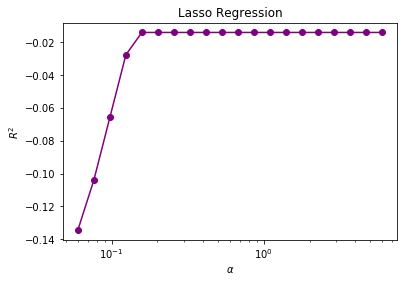

In [39]:
# lasso regression and K-fold cross validation
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV, ElasticNetCV 
s = StandardScaler()
pf = PolynomialFeatures(degree=2)
kf = KFold(shuffle=True, random_state=72018, n_splits=3)
scores = []
alphas = np.geomspace(0.06, 6.0, 20)
predictions_lsr = []
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("make_higher_degree", pf),
        ("lasso_regression", las)])

    predictions_lsr = cross_val_predict(estimator, X_train, y_train, cv = kf)
    
    score = r2_score(y_train, predictions_lsr)
    
    scores.append(score)
plt.semilogx(alphas, scores, '-o', color='purple')
plt.title('Lasso Regression')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

In [40]:

best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.03))])

best_estimator.fit(X_train, y_train)
lasso_score = best_estimator.score(X_train, y_train)



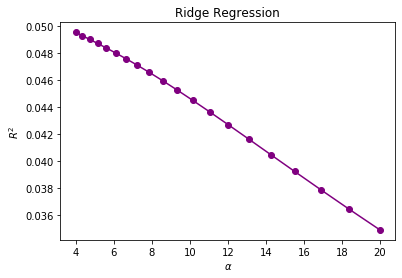

In [41]:
# ridge regression and K-fold cross validation
pf = PolynomialFeatures(degree=2)
alphas = np.geomspace(4, 20, 20)
scores=[]
predictions_rr = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000)

    estimator = Pipeline([
        ("scaler", s),
        ("polynomial_features", pf),
        ("ridge_regression", ridge)])

    predictions_rr = cross_val_predict(estimator, X_train, y_train, cv = kf)
    score = r2_score(y_train, predictions_rr)
    scores.append(score)

plt.plot(alphas, scores, '-o', color='purple')
plt.title('Ridge Regression')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

In [42]:
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("ridge_regression", Ridge(alpha=0.03))])

best_estimator.fit(X_train, y_train)
ridge_score = best_estimator.score(X_train, y_train)

In [43]:
# comparing scores
pd.DataFrame([[linear_score, lasso_score, ridge_score]],columns=['linear', 'lasso', 'ridge'], index=['score'])

,linear,lasso,ridge
score,-5.587182,0.517032,0.999998


In [44]:
def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

# Fit a basic linear regression model
linearRegression = LinearRegression().fit(X_train, y_train)
linearRegression_rmse = rmse(y_test, linearRegression.predict(X_test))

# Fit a regular (non-cross validated) Ridge model
alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]
ridgeCV = RidgeCV(alphas=alphas, cv=4).fit(X_train, y_train)
ridgeCV_rmse = rmse(y_test, ridgeCV.predict(X_test))

# Fit a Lasso model using cross validation and determine the optimum value for 𝛼
alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])
lassoCV = LassoCV(alphas=alphas2,
                  max_iter=5e4,
                  cv=3).fit(X_train, y_train)
lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))

# Fit elastic net with the same set of alphas as lasso
l1_ratios = np.linspace(0.1, 0.9, 9)
elasticNetCV = ElasticNetCV(alphas=alphas2, 
                            l1_ratio=l1_ratios,
                            max_iter=1e4).fit(X_train, y_train)
elasticNetCV_rmse = rmse(y_test, elasticNetCV.predict(X_test))


rmse_vals = [linearRegression_rmse, ridgeCV_rmse, lassoCV_rmse, elasticNetCV_rmse]

labels = ['Linear', 'Lasso', 'Ridge' 'ElasticNet']

rmse_df = pd.DataFrame([[linearRegression_rmse, ridgeCV_rmse, lassoCV_rmse, elasticNetCV_rmse]],columns=['Linear', 'Lasso', 'Ridge', 'ElasticNet'], index=['rmse'])
rmse_df



,Linear,Lasso,Ridge,ElasticNet
rmse,3.411869,0.177438,1.925086,3.027785


[Text(0, 0.5, 'Predicted'),
 Text(0.5, 0, 'Actual'),
 Text(0.5, 1.0, 'Linear Regression Results')]

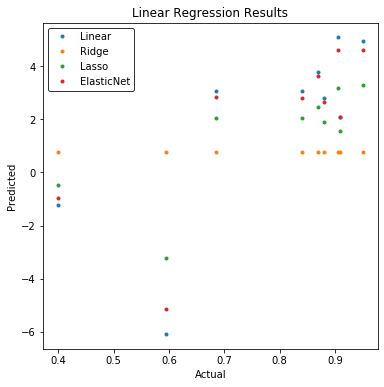

In [45]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()

labels, models = ['Linear', 'Ridge', 'Lasso', 'ElasticNet'], [linearRegression, ridgeCV, lassoCV, elasticNetCV]

for mod, label in zip(models, labels):
    ax.plot(y_test, mod.predict(X_test), marker='o', ls='', ms=3.0, label=label, alpha=1)
    
leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.0)

ax.set(xlabel='Actual', ylabel='Predicted', title='Linear Regression Results')